# Convolutional neural network

## Librairies

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Constantes du dataset et de l'entraînement

In [2]:
PATH = "Dataset/"
IMAGE_TYPE = ["Brain Tumor CT scan Images", "Brain Tumor MRI images"]
PATIENT_TYPE = ["Healthy", "Tumor"]

WEIGHTS_PATH1 = "Model/ct_best.weights.h5"
WEIGHTS_PATH2 = "Model/mri_best.weights.h5"
WEIGHTS_PATH3 = "Model/commun_best.weights.h5"

SIZE = (128, 128)
BATCH = 64
EPOCHS = 10
BUFFER = 1024

#### Gestion des fichiers créés pendant l'entrainement

In [3]:
def remove_file(path):
    try:
        os.remove(path)
    except OSError:
        pass

os.makedirs("Model/", exist_ok=True)
remove_file(WEIGHTS_PATH1)
remove_file(WEIGHTS_PATH2)
remove_file(WEIGHTS_PATH3)

## Récupération des dataset

- Toutes les images contenues dans le dataset ne sont pas de la **même tailles**, et ne sont pas toutes carrées. A cause de ca on a été obligé de faire un pré-traitement des images pour garantir le bon entraînement du modèle.

  - On a choisi de redimensionner les images en tailles **(128 * 128) pixels**, c'est un juste milieu entre une bonne précision et un temps d'entrainement trop long car le nombre de paramètre de notre modèle augmente drastiquement en fonction de la taille de l'entrée.
  - Dans un premier temps nous avions essayé de redimensionner en tailles (192 * 192) mais le temps de calcule était presque doublé tandis que la précision n'a pas changé.

- On garde les images comme si elles étaient en couleur (rgb) car la précision du modèle diminue si nous décidons de les transformer en *grayscale* (même si a première vue elles sont en noir et blanc).
- On utilise **70%** des données pour l'entrainement et **30%** pour la validation.

In [4]:
# Dataset des CT scans
ct_train_ds, ct_val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=PATH + IMAGE_TYPE[0],
    label_mode='categorical',
    color_mode='rgb',
    batch_size=None,
    image_size=SIZE,
    shuffle=True,
    seed=7,
    validation_split=0.3,
    subset='both',
    verbose=True
)

# Dataset des IRM
mri_train_ds, mri_val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=PATH + IMAGE_TYPE[1],
    label_mode='categorical',
    color_mode='rgb',
    batch_size=None,
    image_size=SIZE,
    shuffle=True,
    seed=7,
    validation_split=0.3,
    subset='both',
    verbose=True
)

Found 4618 files belonging to 2 classes.
Using 3233 files for training.
Using 1385 files for validation.
Found 5000 files belonging to 2 classes.
Using 3500 files for training.
Using 1500 files for validation.


## Préparation du dataset

- **Concatenations** des 2 datasets pour créer un grand dataset commun (Scan + IRM).
- **Shuffle** après la concatenation pour que les images de scanner et d'IRM se mélange dans les batchs.
- Mise en **batch** des datasets pour l'entraînement.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = ct_train_ds.concatenate(mri_train_ds).shuffle(buffer_size=BUFFER, seed=11).batch(BATCH).prefetch(AUTOTUNE)
val_ds = ct_val_ds.concatenate(mri_val_ds).shuffle(buffer_size=BUFFER, seed=11).batch(BATCH).prefetch(AUTOTUNE)

ct_train_ds, ct_val_ds = ct_train_ds.batch(BATCH).prefetch(AUTOTUNE), ct_val_ds.batch(BATCH).prefetch(AUTOTUNE)
mri_train_ds, mri_val_ds = mri_train_ds.batch(BATCH).prefetch(AUTOTUNE), mri_val_ds.batch(BATCH).prefetch(AUTOTUNE)

## Visualisation d'images du dataset

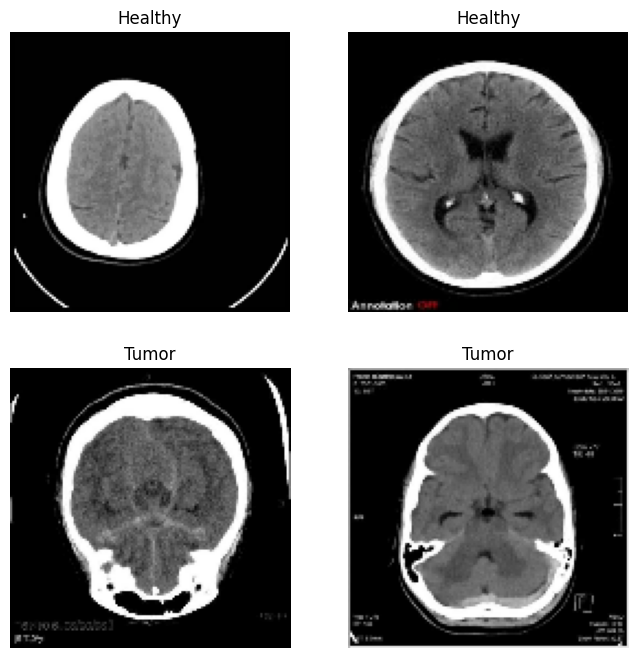

In [10]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        label_index = tf.argmax(labels[i]).numpy()
        plt.title(PATIENT_TYPE[label_index])
        plt.axis('off')

## Visualisation de la qualité de l'entraînement

- Créé un graphe pour visualiser la valeur de loss du modèle sur les dataset d'entraînement et de validation pour chaque epochs.
- Créé un second graphe pour visualiser la valeur de précision du modèle sur les dataset d'entraînement et de validation pour chaque epochs.

In [11]:
def plot_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(1, len(history.history['loss']) + 1)

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

## Définition du CNN

On a choisi de faire un CNN avec 4 couches **convolutive** chacune suivie d'une couche de **pooling**.
- On commence par faire un **Rescaling**, ca permet d'avoir des valeurs d'entrée sur [0, 1] et d'améliorer la stabilité et la vitesse d'apprentissage.
- Pour la première convolution on applique un **filtre (5, 5)** pour favoriser la détection de grand motifs.
- Ensuite on utilise des **filtres (3, 3)** car l'image étant seulement de taille (128, 128) celà suffit à ce que les motifs se propage au fur des convolutions.
- Les couches denses du MLP sont de tailles **(1024, 128, 2)**:
  - 1024 permet de pouvoir bien capter les différents motifs de l'image;
  - 128 pour affiner le résultat;
  - une sortie avec 2 perceptron en activation softmax permet d'avoir une **probabilité** de Tumeur ou non avec la somme égale à 1 (parfait pour la reconnaissance d'image que nous voulons).

In [12]:
def cnnModel():
    model = Sequential()
    model.add(keras.layers.Input(shape=(128, 128, 3)))
    model.add(keras.layers.Rescaling(1./255))
    # Layer 1
    model.add(keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    # Layer 2
    model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    # Layer 3
    model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    # Layer 4
    model.add(keras.layers.Conv2D(192, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    # Flatten
    model.add(keras.layers.Flatten())

    # MLP
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    return model

## Entraînement des modèles

Utilisation du "callback ModelCheckpoint" qui permet d'enregistrer les paramètres de la meilleure époque (minimum de validation loss) afin de garder le meilleur modèle (particulièrement utile en cas d'overfitting).

#### 1. Pour entraîné le modèle des **Scanner**

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - accuracy: 0.7268 - loss: 0.6276 - val_accuracy: 0.8953 - val_loss: 0.2542
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 435ms/step - accuracy: 0.9220 - loss: 0.1860 - val_accuracy: 0.9350 - val_loss: 0.1848
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 423ms/step - accuracy: 0.9531 - loss: 0.1238 - val_accuracy: 0.9466 - val_loss: 0.1275
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 421ms/step - accuracy: 0.9604 - loss: 0.0836 - val_accuracy: 0.9581 - val_loss: 0.1201
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 416ms/step - accuracy: 0.9695 - loss: 0.0773 - val_accuracy: 0.9552 - val_loss: 0.1263
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 415ms/step - accuracy: 0.9588 - loss: 0.0882 - val_accuracy: 0.9653 - val_loss: 0.0938
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 413ms/step - accuracy: 0.9831 - loss: 0.0396 - val_accuracy: 0.9639 - val_loss: 0.1004
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 418ms/step - accuracy: 0.9855 - loss: 0.0417 - val_accu

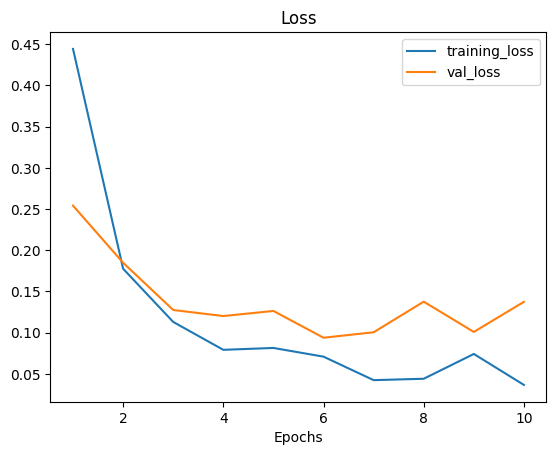

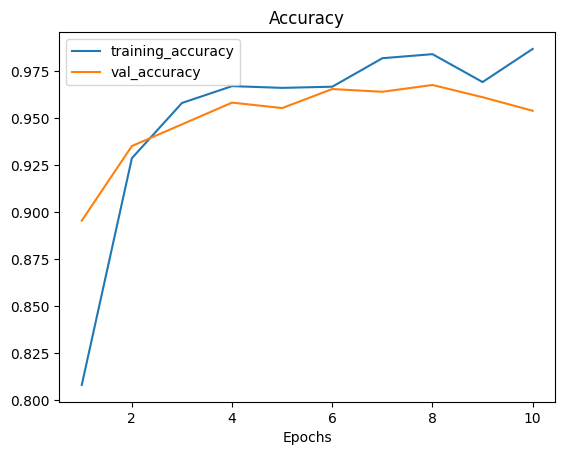

In [14]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=WEIGHTS_PATH1,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

model_ct = cnnModel()
history_ct = model_ct.fit(ct_train_ds, validation_data=ct_val_ds, epochs=EPOCHS, callbacks=[checkpoint_callback])
model_ct.load_weights(WEIGHTS_PATH1)
plot_curves(history_ct)

#### 2. Pour entraîné le modèle des **IRM**

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 409ms/step - accuracy: 0.6372 - loss: 0.6384 - val_accuracy: 0.8453 - val_loss: 0.3655
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 409ms/step - accuracy: 0.8566 - loss: 0.3474 - val_accuracy: 0.8873 - val_loss: 0.2605
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 419ms/step - accuracy: 0.9182 - loss: 0.2106 - val_accuracy: 0.9267 - val_loss: 0.1821
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 423ms/step - accuracy: 0.9508 - loss: 0.1286 - val_accuracy: 0.9473 - val_loss: 0.1254
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 440ms/step - accuracy: 0.9701 - loss: 0.0699 - val_accuracy: 0.9560 - val_loss: 0.1028
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 416ms/step - accuracy: 0.9769 - loss: 0.0603 - val_accuracy: 0.9693 - val_loss: 0.0919
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 416ms/step - accuracy: 0.9887 - loss: 0.0288 - val_accuracy: 0.9760 - val_loss: 0.0737
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 417ms/step - accuracy: 0.9927 - loss: 0.0199 - val_accu

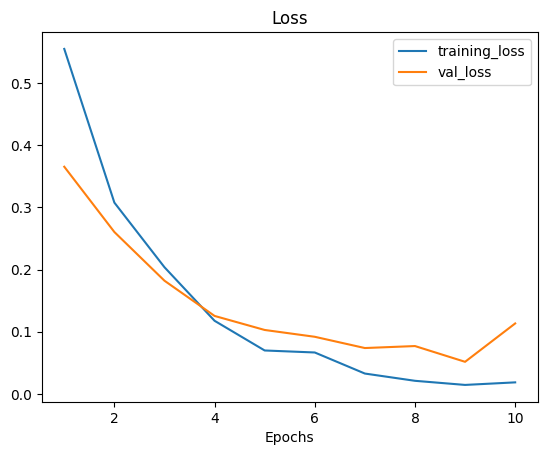

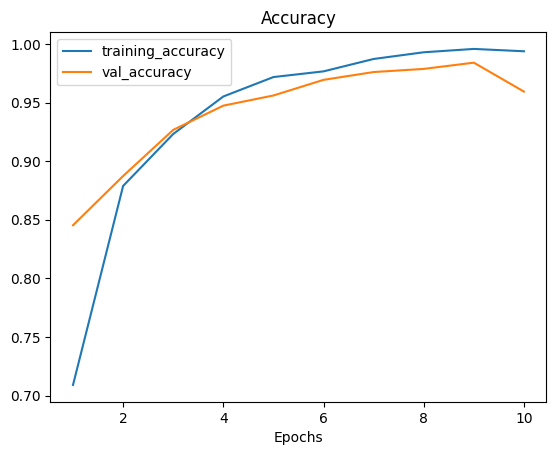

In [15]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=WEIGHTS_PATH2,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

model_mri = cnnModel()
history_mri = model_mri.fit(mri_train_ds, validation_data=mri_val_ds, epochs=EPOCHS, callbacks=[checkpoint_callback])
model_mri.load_weights(WEIGHTS_PATH2)
plot_curves(history_mri)

#### 3. Pour entraîné le modèle des **Scanner et des IRM**

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 44s 408ms/step - accuracy: 0.7379 - loss: 0.5076 - val_accuracy: 0.8614 - val_loss: 0.3594
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 44s 409ms/step - accuracy: 0.9033 - loss: 0.2346 - val_accuracy: 0.8971 - val_loss: 0.2661
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 44s 408ms/step - accuracy: 0.9326 - loss: 0.1665 - val_accuracy: 0.9127 - val_loss: 0.2391
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 44s 408ms/step - accuracy: 0.9431 - loss: 0.1445 - val_accuracy: 0.9220 - val_loss: 0.2366
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 45s 418ms/step - accuracy: 0.9467 - loss: 0.1207 - val_accuracy: 0.9536 - val_loss: 0.1323
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 45s 420ms/step - accuracy: 0.9600 - loss: 0.0823 - val_accuracy: 0.9612 - val_loss: 0.1189
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 45s 421ms/step - accuracy: 0.9769 - loss: 0.0626 - val_accuracy: 0.9681 - val_loss: 0.1074
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 45s 423ms/step - accuracy: 0.9725 - loss: 0

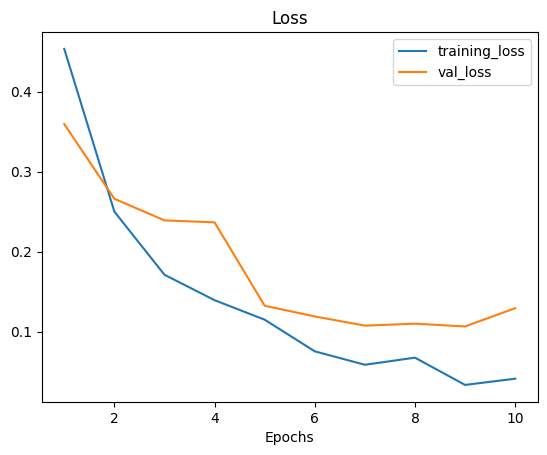

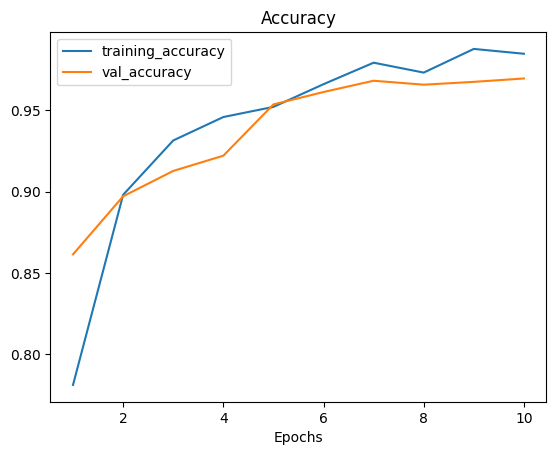

In [16]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=WEIGHTS_PATH3,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

model_commun = cnnModel()
history_commun = model_commun.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[checkpoint_callback])
model_commun.load_weights(WEIGHTS_PATH3)
plot_curves(history_commun)

## Evaluation

Permet de voir les performances de nos modèles par rapport à la loss et à la précision, sur le dataset de validation.

#### 1. Pour le modèle entraîné sur les **Scanner**

In [17]:
test_loss, test_accuracy = model_ct.evaluate(ct_val_ds)
print(f"Loss: {test_loss:.4f}   |   Accuracy: {test_accuracy*100:.1f}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9670 - loss: 0.0868
Loss: 0.0938   |   Accuracy: 96.5%


#### 2. Pour le modèle entraîné sur les **IRM**

In [18]:
test_loss, test_accuracy = model_mri.evaluate(mri_val_ds)
print(f"Loss: {test_loss:.4f}   |   Accuracy: {test_accuracy*100:.1f}%")

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9880 - loss: 0.0406
Loss: 0.0516   |   Accuracy: 98.4%


#### 3. Pour le modèle entraîné sur les **Scanner et IRM**

In [19]:
test_loss, test_accuracy = model_commun.evaluate(val_ds)
print(f"Loss: {test_loss:.4f}   |   Accuracy: {test_accuracy*100:.1f}%")

46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9593 - loss: 0.1268 
Loss: 0.1064   |   Accuracy: 96.7%


## Sauvegarde et Chargement des modèles

#### 1. Pour le modèle entraîné sur les **Scanner**

In [20]:
# Sauvegarde du modèle scanner
model_ct.save('Model/cnn_ct.keras')

In [21]:
# Chargement du modèle scanner
model_ct = keras.models.load_model('Model/cnn_ct.keras')
# model_ct.summary()

#### 2. Pour le modèle entraîné sur les **IRM**

In [22]:
# Sauvegarde du modèle IRM
model_mri.save('Model/cnn_irm.keras')

In [23]:
# Chargement du modèle IRM
model_irm = keras.models.load_model('Model/cnn_irm.keras')
# model_irm.summary()

#### 3. Pour le modèle entraîné sur les **Scanner et IRM**

In [24]:
# Sauvegarde du modèle commun
model_commun.save('Model/cnn_commun.keras')

In [25]:
# Chargement du modèle commun
model_commun = keras.models.load_model('Model/cnn_commun.keras')
# model_commun.summary()